# AI


## Bibliotecas utilizadas

In [23]:
import osmnx as ox
import matplotlib.pyplot as plt
import contextily as ctx

from helper_functions import Graph, BancoDeHemocentros

## Preparando o problema

### Gerando um grafo da cidade
Vamos começar gerando o grafo da cidade em que nosso sistema vai rodar. No caso, escolhemos a cidade de São Carlos. Com a biblioteca `osmnx`, conseguimos gerar esse grafo e salvá-lo em um arquivo `.graphml`. Essa biblioteca é especializada em redes urbanas, utilizando dados geoespaciais reais para gerar um grafo de uma determinada região.

A classe `Graph` definida em `helper_functions.py` abstrai algumas funcionalidades que iremos precisar mais adiante. Para utilizar  

In [24]:
# # Nome da cidade
# cidade = "São Carlos, São Paulo, Brasil"

# # Baixa o grafo das ruas para transporte por carro (modo drive)
# G = ox.graph_from_place(cidade, network_type='drive')
# ox.save_graphml(G, filepath="sao_carlos.graphml")

Número de nós: 9042
Número de arestas: 22340


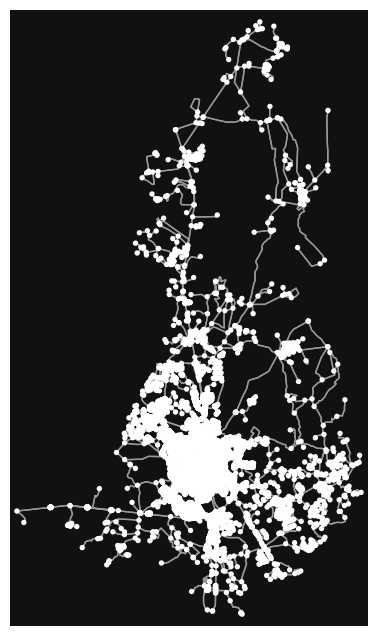

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [25]:
# INSTANCIANDO A CLASSE GRAPH CRIADA
G = Graph("sao_carlos.graphml")

# Mostra informações do grafo
print(f"Número de nós: {len(G.graph.nodes)}")
print(f"Número de arestas: {len(G.graph.edges)}")

# Desenha o grafo
ox.plot_graph(G.graph)

Essa é a carinha do nosso grafo. Para visualizá-lo melhor, vamos colocar essa rede em cima do mapa real de São Carlos.

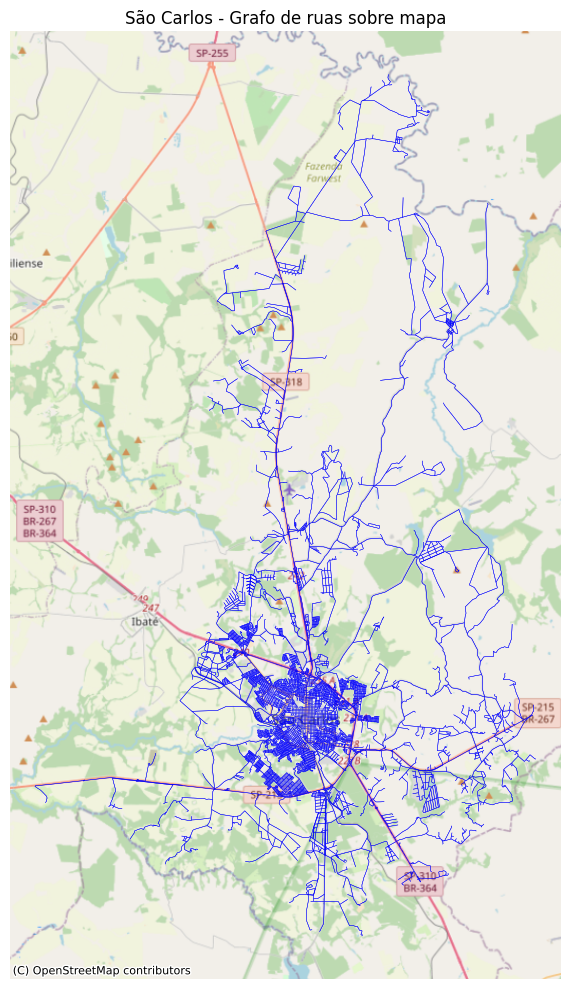

In [26]:
# Plotando as ruas de São Carlos sobre o mapa da cidade
edges = G.edges_gdf

fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=0.3, edgecolor="blue")
ctx.add_basemap(ax, crs=edges.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

plt.title("São Carlos - Grafo de ruas sobre mapa")
plt.tight_layout()

plt.savefig("images/sao_carlos_mapa.png", dpi=300)

plt.show()

### Definindo os Hemocentros
Agora que já possuímos o grafo da cidade toda de São Carlos, devemos definir onde ficarão os `Hemocentros`, que são os nós de interesse do nosso problema de busca (nós finais). Para isso, vamos pegar 7 nós aleatórios, e defini-los como Hemocentros. Na classe já existe um método implementado que retorna n nós aleatórios do grafo, o método `get_random_nodes()`.

Cada nó do grafo é salvo com um ID, isto é, uma String que o identifica. Escolhendo 7 IDs aleatórios, vamos plotar sobre o mapa de São Carlos para visualizá-los.

In [27]:
# Pegando 7 nós aleatórios para representar os hemocentros
hemocentros = G.get_random_nodes(7)
print(hemocentros)

# Converte os hemocentros para GDF (somente para poder plotar)
gdf_hemocentros = G.get_gdf_nodes(hemocentros)

[3299477311, 1013704909, 1029836533, 6804139853, 1013783831, 1152244181, 1029836383]


Vamos semelhantemente ao caso anterior plotar os hemocentros sobre o mapa de São Carlos, a fim de obter uma melhor visualização dos nossos dados. Os círculos vermelhos no mapa representarão a localização dos hemocentros.

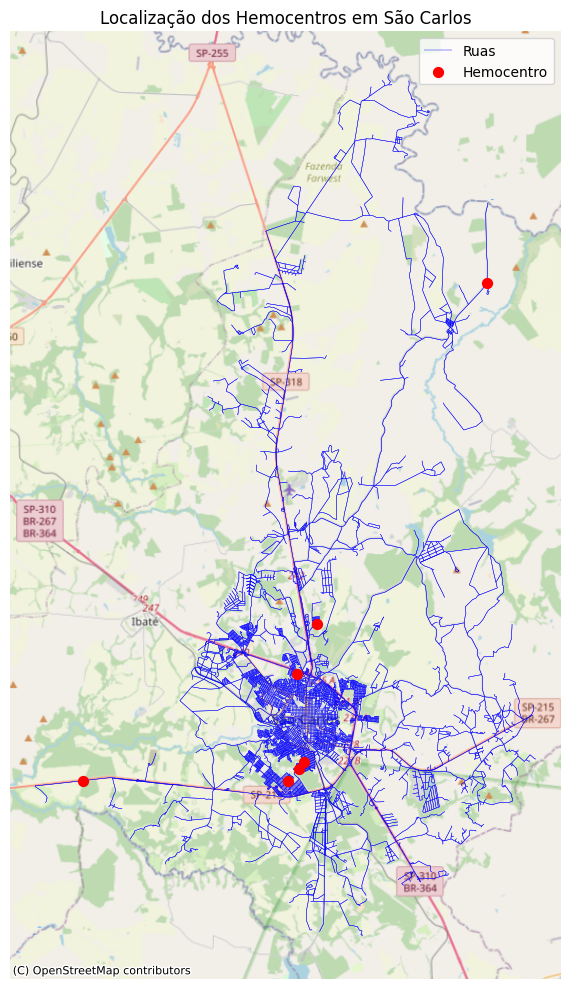

In [28]:
# Plotando o mapa
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=0.3, edgecolor="blue", label='Ruas')
gdf_hemocentros.plot(ax=ax, color="red", markersize=50, zorder=3, label='Hemocentro')

ctx.add_basemap(ax, crs=edges.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

plt.legend()
plt.title("Localização dos Hemocentros em São Carlos")
plt.tight_layout()

plt.savefig("images/hemocentros.png", dpi=300)

plt.show()


Precisamos ainda definir o estoque de determinado tipo sanguíneo em cada um dos hemocentros. Para isso, vamos usar uma outra classe definida em `helper_functions.py`, a classe `Hemocentros`. Essa classe abstrai todo o estoque de bolsas de sangue de todos os hemocentros da cidade de São Carlos (ou de qualquer cidade que utilize o sistema).

In [29]:
H = BancoDeHemocentros(hemocentros, G.graph)

# Exemplo, estoque de bolsas de sangue um hemocentro
H.consultar_estoque(hemocentros[0])

{'A+': 0, 'A-': 0, 'B+': 35, 'B-': 0, 'AB+': 0, 'AB-': 16, 'O+': 0, 'O-': 0}

### Localização do Usuário
Agora, que temos os hemocentros dipostos aleatoriamente, precisamos definir a localização do nó inicial, ou seja, da localização atual do usuário do sistema. Vamos também gerar uma localização aleatória para representar o ponto de partida do grafo.

In [30]:
user = G.get_random_nodes(1)
gdf_user = G.get_gdf_nodes(user)

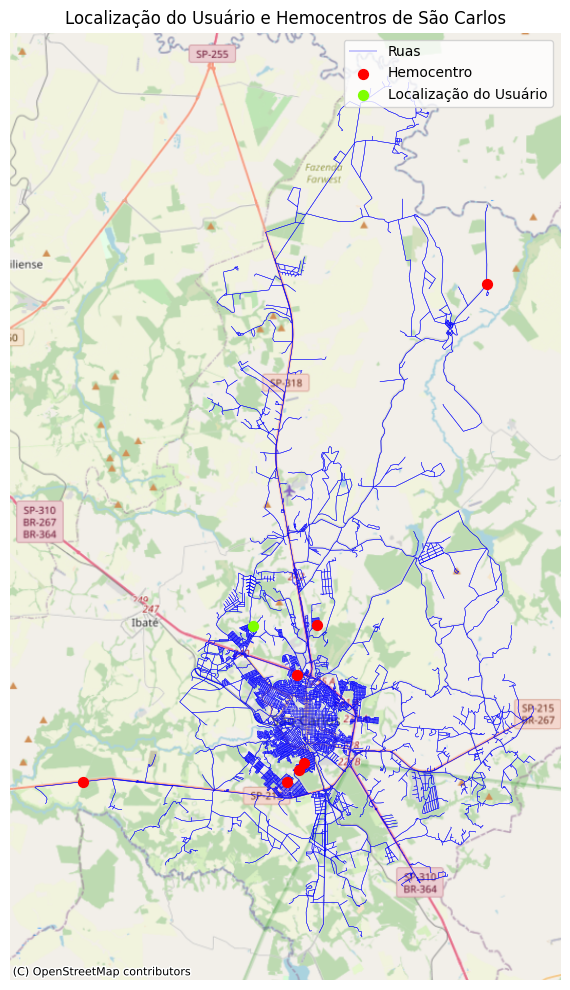

In [31]:
# Plotando o mapa com a localização aleatória
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=0.3, edgecolor="blue", label='Ruas')
gdf_hemocentros.plot(ax=ax, color="red", markersize=50, zorder=3, label='Hemocentro')
gdf_user.plot(ax=ax, color="chartreuse", markersize=50, zorder=3, label='Localização do Usuário')

ctx.add_basemap(ax, crs=edges.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

plt.legend()
plt.title("Localização do Usuário e Hemocentros de São Carlos")
plt.tight_layout()

plt.savefig("images/usuario.png", dpi=300)

plt.show()

## Buscas: DFS e A*
As duas buscas implementadas para solucionar o problema são a Busca em Profundidade (ou Depth-First Search) e o algoritmo A* (A-Estrela). 

Antes de implementar as buscas, o sistema deve ser capaz de identificar através do banco de dados quais hemocentros possuem os tipos sanguíneos doadores compatíveis com o do usuário. Assim, deve-se filtrar os hemocentros que não atendem às necessidades antes de realizar a busca.

In [ ]:
# Definindo o tipo de sangue do usuário e filtrando os HCs válidos
blood_type = "O-"
hcs_validos = H.hemocentros_validos(blood_type)

print(hcs_validos)

[3299477311, 1013704909, 1029836533, 6804139853, 1013783831, 1152244181, 1029836383]
[6804139853, 1013783831]


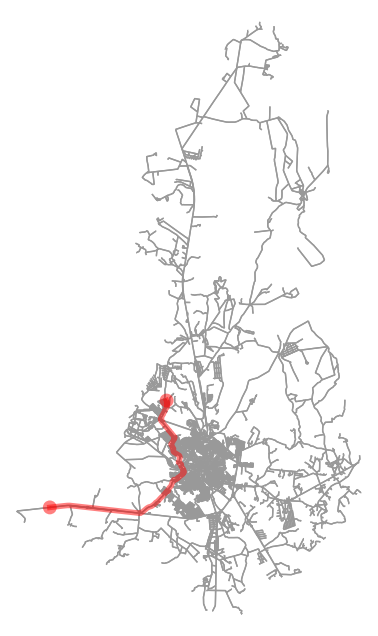

In [36]:
# Teste da função já implementada, não usar
rota = G.calcular_rota(user[0], hcs_validos[0])
G.plotar_rota(rota)

### Busca não informada: DFS (Depth-First Search)
A Busca em Profundidade (ou do inglês, Depth-First Search) consiste em testar insistentemente todos os caminhos mais profundos, antes de partir para a próxima escolha. 

In [ ]:
G.graph.nodes[user[0]]

AttributeError: 'dict' object has no attribute 'successors'

### Busca Informada: A* (A-Star)
O algoritmo A* (A-Estrela) de busca em grafos é um tipo de busca informada, no qual utiliza-se de uma heurística...